In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import gsw
import string
import warnings
warnings.filterwarnings('ignore')
from matplotlib.lines import Line2D
from tqdm import tqdm
import os
import sys

# Set the path for the src directory
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from paths import f75, f300, figpath, datapath, file_bathymetry_along_fjord
from velocity_preprocessing_functions import open_and_proces_mat_adcp
from functions import TSdiagram
from import_transect_data import df_all

# Specific functions for plotting
Extract transect
Add secondary axis
Plot station triangles
bathymetry_line

In [11]:
def colors(var, nrows=3):
    alphabet = list(string.ascii_lowercase)
    alphabet = alphabet + [i+j for i in alphabet for j in alphabet]
    if (var == 'CT' ) or (var=='Potential temperature [°C]'):
        levels = np.arange(0,3.5,0.2)
        subplot_letter = alphabet[:nrows]
        colorscale = "cmo.thermal"
        clabel= "Conservative Temperature [°C]"

    elif (var == 'SA') or (var=="Salinity [PSU]"):
        levels = np.arange(33.2,33.7,0.025)
    
        subplot_letter = alphabet[nrows:nrows*2]
        colorscale = "cmo.haline"
        clabel= "Salinity [g/kg]"
    return levels, subplot_letter, colorscale, clabel

def grid_data(x, y, z, interval_x=1, interval_y=1, interpolate=False):
    if interpolate:
        # define grid.
        offset_x = ((max(x)-min(x))%1)/2  # to make sure the grid is centered
        xi = np.arange(min(x)+offset_x, max(x), interval_x)
        yi = np.arange(min(y), max(y), interval_y)
        # grid the data.
        zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
    else:
        xi = x.sort_values().unique()
        yi = y.sort_values().unique()
        zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')
    return xi, yi, zi

def mm2inch(value):
    return value/25.4  # centimeters in inches

def fmt_label(x):
    s = f"{x:.1f}"
    if s.endswith(".0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

def extract_transect(df):
    '''
    takes df with all stations and returns a dataframe with only one row per station
    handy to make plots
    reurns data frame
    '''
    df_transect = pd.DataFrame()
    for name in df.Name.unique():
        row = (df[df.Name == name].iloc[0,:])
        # add row to a data frame
        df_transect = pd.concat([df_transect, row], axis=1)

    return df_transect.T.set_index('Name',drop=True).sort_values(['Distance'])

def add_secondary_axis(ax, xticks, xticklabels):
    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("")
    secax.set_xticks(xticks)
    secax.set_xticklabels(xticklabels, rotation=0, fontsize=8)
    secax.title.set_position([0.1,1])
    return secax


def plot_stations(df, ax, depth=100, text=True, text_offset=5, max_distance=None, s=100):
    '''
    plot station locations on transect plot with triangles
    takes df used
    ax = ax in subplot
    depth = depth at which to plot the stations
    text = True if you want to annotate the stations
    text_offset = offset of the text depth in order to not overlap 
    max_distance = dont plot station outside this range
    '''
    df_transect = extract_transect(df)
    if max_distance:
        df_transect = df_transect[df_transect.Distance <= max_distance]
    ax.scatter(df_transect.Distance, np.repeat(depth, len(df_transect)), marker='v', color='k', edgecolors='white', s=s, zorder=10, linewidths=2)
    # annotate the stations
    if text:
        for i, txt in enumerate(df_transect['St.']):
            ax.annotate(txt, (df_transect.Distance[i], depth+text_offset), rotation=0, fontsize=10,  annotation_clip=False, ha='center', va='bottom')
    return df_transect.Distance.values, df_transect['St.'].values

def bathymetry_line(ax):
    '''Add bathymetry to matplotlib subplot
    ax = ax in subplot'''
    ## bathymetry
    df_bath = pd.read_csv(file_bathymetry_along_fjord)
    ax.plot(df_bath["Distance [km]"],df_bath.Depth, color='k', linewidth=1, alpha=0.5, zorder=15)
    ax.fill_between(df_bath["Distance [km]"],np.repeat(-650, len(df_bath)), df_bath.Depth, color='white', linewidth=1,  alpha=1, zorder=14) # adding bathymetry

## Import velocity vectors

In [5]:

def import_velocity_data(Hz="75", St="GF10"):
    '''
    import velocity data from a netcdf file
    returns a data set
    '''
    if (St == "GF10") & (Hz == "75"):
        ds_velo, _, df_cons75, _, _, _, _, _, _, ds_velo_no_outlier_removal_75 = open_and_proces_mat_adcp(f75)
    elif (St == "GF10") & (Hz == "300"):
        ds_velo, _, df_cons300, _, _, _, _, _, _, ds_velo_no_outlier_removal_300 = open_and_proces_mat_adcp(f300)
    return ds_velo

ds_velo_75 = import_velocity_data(Hz="75", St="GF10")
ds_velo_300 = import_velocity_data(Hz="300", St="GF10")

def add_velocity_vectors(ax, date, n =2, width=1.0, velocity_day=1, Hz=75, nmeters=1):
    ''' Adding daily mean velocity vectors, currently only for 75khz at GF10
    n = plot every nth vector
    nmeters= ever n meters, only use when using both 75 and 300 khz, step size determined by ceil(nmeters/binsize)'''
    #resample per day and choose date from dates_spring_inflow
    if Hz == 75:
        velo_select = ds_velo_75.resample(time='1D').mean()
    elif Hz == 300:
        velo_select = ds_velo_300.resample(time='1D').mean()
    else:
        n= 1
        velo_select = xr.merge([ds_velo_75.resample(time='1D').mean().sel(z=slice(None, None, int(np.ceil(nmeters/16)))), ds_velo_300.resample(time='1D').mean().sel(z=slice(None, None, int(np.ceil(nmeters/2))))])

    if velocity_day == 1:
        velo_select=velo_select.sel(time=date, z=slice(None, None, n))
    else:
        bandwidth_days = np.floor(velocity_day/2)
        velo_select=velo_select.sel(time=slice(pd.to_datetime(date)-pd.to_timedelta(bandwidth_days,'days'), pd.to_datetime(date)+pd.to_timedelta(bandwidth_days,'days')), z=slice(None, None, n)).mean(dim='time')
    return ax.quiver(np.repeat(94, len(velo_select.z)), velo_select.z*-1, velo_select.Alongmmpersec, 0,width=width, linewidth=0.3, edgecolor='white', scale = 600)



## color bar

In [6]:
lon= -51.18810619555545
lat = 64.47646334793227
mean_sal = 33.234548899892154
mean_pres = 239.38910736127735

# i checked for sensititivity of the conversion to the mean pressure and salinity but it is very small in these ranges

def SAtoPS(x):
    '''Converts Absolute Salinity to Practical Salinity'''
    return gsw.SP_from_SA(x, mean_pres,  lon=lon,lat=lat)
def PStoSA(x):
    '''Converts Practical Salinity to Absolute Salinity'''
    return gsw.SA_from_SP(x, mean_pres, lon=lon,lat=lat)
def CTtoPT(x):
    '''Converts Conservative Temperature to Potential Temperature'''
    return gsw.pt_from_CT(mean_sal, x)
def PTtoCT(x):
    '''Converts Potential Temperature to Conservative Temperature'''
    return gsw.CT_from_pt(mean_sal, x)

In [7]:
def add_top_colorbars(fig, cCT, cSA, y_pos=0.95, y_height=0.03, second_cbar_ax=False, templabel=r"CT [$^\circ$C]", sallabel='SA [g/kg]'):
    '''
    add colorbars to the top of the figure with two columns of subplots
    y_pos = position of the colorbar relative to the figure
    y_height = height of the colorbar relative to the figure
    '''
    # colorbars
    # Create axes for colorbars
    cbar_ax1 = plt.axes([0.13, y_pos, 0.35, y_height])
    cbar_ax2 = plt.axes([0.54, y_pos,  0.35, y_height])
    # Create colorbars for each subplot
    cbar_CT = fig.colorbar(cCT, cax=cbar_ax1, orientation='horizontal')
    cbar_SA = fig.colorbar(cSA, cax=cbar_ax2, orientation='horizontal')
    # only show every second label on cbar_SA
    # cbar_SA.set_ticks(cbar_SA.get_ticks()[::2])
    cbar_ax1.tick_params(size=0)
    cbar_ax2.tick_params(size=0)
    # add cbar labels
    cbar_CT.set_label(templabel)
    cbar_SA.set_label(sallabel)
    for cbarax in [cbar_ax1, cbar_ax2]:
        cbarax.xaxis.set_ticks_position('bottom')
        cbarax.xaxis.set_label_position('bottom')
        cbarax.tick_params(labelsize=10)

    if second_cbar_ax:
        ticks = cbar_CT.get_ticks()
        ticks2 = CTtoPT(ticks).round(1)
        pos = cbar_ax1.get_position()
        cbar_ax1.set_aspect('auto')
        ax2_CT = cbar_ax1.twiny()
        ax2_CT.set_xlim([min(ticks2), max(ticks2)])
        ax2_CT.set_xticks(ticks2)
        ax2_CT.set_position(pos)
        ax2_CT.set_xlabel('PT [$^\circ$C]')

        ticks = cbar_SA.get_ticks()
        ticks2 = SAtoPS(ticks).round(2)
        pos = cbar_ax2.get_position()
        cbar_ax2.set_aspect('auto')
        ax2_SA = cbar_ax2.twiny()
        ax2_SA.set_xlim([min(ticks2), max(ticks2)])
        ax2_SA.set_xticks(ticks2)
        ax2_SA.set_position(pos)
        ax2_SA.set_xlabel('PSU')
        for ax in [ax2_CT, ax2_SA]: ax.tick_params(size=0)


def add_colorbar_john(fig, cCT, cSA, y_pos=0.95, y_height=0.03, second_cbar_ax=False, templabel=r"$\theta$ [$^\circ$C]", sallabel='Salinity', Tticks = None):
    # recttuple (left, bottom, width, height)
    cbar_ax1 = fig.add_axes([0.13, y_pos, 0.35, y_height])
    cbar_ax2 = fig.add_axes([0.54, y_pos,  0.35, y_height])

    # Create colorbars for each subplot
    cbar_CT = fig.colorbar(cCT, cax=cbar_ax1, orientation='horizontal', extend= None, spacing='uniform')
    cbar_SA = fig.colorbar(cSA, cax=cbar_ax2, orientation='horizontal',extend= None, spacing='uniform')
    # only show every second label on cbar_SA
    # cbar_SA.set_ticks(cbar_SA.get_ticks()[::2])
    if Tticks is not None:
        cbar_CT.set_ticks(Tticks)
    cbar_ax1.tick_params(size=0)
    cbar_ax2.tick_params(size=0)
    # add cbar labels
    cbar_CT.set_label(templabel)
    cbar_SA.set_label(sallabel)
    for cbarax in [cbar_ax1, cbar_ax2]:
        cbarax.xaxis.set_ticks_position('top')
        cbarax.xaxis.set_label_position('top')
        cbarax.tick_params(labelsize=10)
        cbarax.xaxis.set_major_formatter(lambda x, _: f'{x:g}')

In [8]:
def melt_line(T, S, Sarray, slope=2.94):
    '''Draw a line that goes through point T on the y-axis and S on the x-axis, with a default slope of 2.94, for all point sin Sarray'''
    b = T - slope*S
    return slope*Sarray + b

def mix_line(T, S,Sarray):
    ''' Draw a line through 0 salinity and 0 temperature and through point T and S'''
    slope = T/S
    b = 0
    return slope*Sarray + b

def plot_TS_diagram(df, ax, date, T='CT', S='SA', color='k', label=None, linestyle='-', linewidth=1):
    '''Plot a TS diagram for a given date, with default T and S being CT and SA'''
    df = df[df.Date == date]
    ax.scatter( df[S], df[T],  label=label, linestyle=linestyle, linewidth=linewidth)
    return ax


# draw a box of 33.5 to 33.6 and 0.5 to 1.5
def rectangle_corner_points(Smin, Smax, Tmin, Tmax):
    '''Draw a rectangle with corner points Smin, Smax, Tmin, Tmax'''
    return [[Smin, Tmin], [Smin, Tmax], [Smax, Tmax], [Smax, Tmin], [Smin, Tmin]]
# ax.plot(*np.array(rectangle_corner_points(33.5, 33.6, 0.5, 1.5)).T,  linewidth=1)
# 
def add_water_mass(ax):
    dfWaterMass = pd.read_excel(f"{datapath}/processed/Water_masses_Mortensen_2011.xlsx").rename(columns={ 'T (Potential Temperature)':'T',  'S (Practical Salinity)':'S'})
    ax.scatter(dfWaterMass['S'], dfWaterMass['T'], s=5, color='k', marker='x')
    for j, txt in enumerate(dfWaterMass.Abbreviation):
        ax.annotate(txt, (dfWaterMass['S'][j], dfWaterMass['T'][j]+0.2), ha='center', va='center')


def get_transect_data(date) :
    dfdate = df_all[(df_all.Plot_date == date)]

    return dfdate


# Profiles and transects

# Figure 4

5it [00:11,  2.28s/it]
5it [00:11,  2.30s/it]


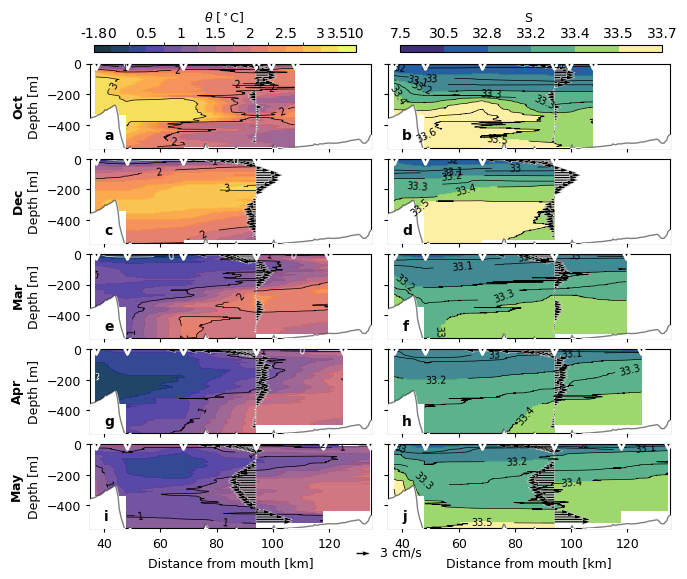

In [18]:


dates = [['2018-10-31', '2018-12-11', '2019-03-05', '2019-04-10', '2019-05-06']]
phases = ['', '', '', '', '']

levels50 = [10, 20, 25, 30, 31, 32, 33]
maxz = 550
velocity_day = 3

alphabet = list(string.ascii_lowercase)
n = len(np.squeeze(dates))


plt.rcParams.update({'font.size': 9})
color_overview = plt.cm.viridis(len(dates))

unique_distances = np.sort(df_all['Distance'].unique())
min_distance = unique_distances[0]

for maxz in [550]:
    plot_height = 15 / 7.5
    nr_rows = len(dates[0])
    fig, axs = plt.subplots(nr_rows, 2, sharey=True, sharex=True, figsize=(mm2inch(190), mm2inch(230 / 1.5)))

    for i, contour_var in enumerate(['Potential temperature [°C]', 'Salinity [PSU]']):
        for j, date in tqdm(enumerate(dates[0])):
            z_var = 'Depth'
            df = get_transect_data(date=date)
            xi, yi, zi = grid_data(df.Distance, df[z_var], df[contour_var], interval_x=5, interval_y=2)
            if contour_var == 'Potential temperature [°C]':
                colorscale = mpl.colors.ListedColormap(cmo.cm.thermal(np.linspace(0, 1, 15)))
                cmap = colorscale
                bounds = [-1.8, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.5, 10]
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                levels_l = [-1.8, 0, 1, 2, 3, 3.5, 10]
                color_contourline = np.array(['black' if i > 0 else 'white' for i in levels_l])
                xlim_profile = [-0.5, 4] if maxz >= 200 else [-1.8, 3.3]
                xlim_profile_T = xlim_profile
            else:
                colorscale = mpl.colors.ListedColormap(cmo.cm.haline(np.linspace(0, 1, 6)))
                cmap = colorscale
                bounds = [7.5, 30.5, 32.8, 33.2, 33.4, 33.5, 33.7]
                norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
                levels_l = np.sort(np.concatenate([np.arange(30, 33, 1), np.arange(33, 33.56, 0.1), np.arange(33.6, 35.1, 0.4)]))
                xlim_profile = [32.9, 33.65] if maxz >= 200 else [30, 33.8]
                color_contourline = np.array(['black' if i >= 30.5 else 'white' for i in levels_l])
                xlim_profile_S = xlim_profile
                short_label = 'Salinity'
            levels = bounds

            cfill = axs[j, i].contourf(xi, yi, zi, levels=bounds, cmap=colorscale, extend=None, norm=norm, alpha=0.9)
            cline = axs[j, i].contour(xi, yi, zi, levels=levels_l, colors=color_contourline, linewidths=0.5)
            axs[j, i].clabel(cline, cline.levels, inline=True, fontsize=7, zorder=16, fmt=fmt_label)
            plot_stations(df, axs[j, i], depth=0, text=False, s=50)
            bathymetry_line(axs[j, i])
            q = add_velocity_vectors(axs[j, i], pd.to_datetime(date) - pd.Timedelta(days=1), n=2, width=6e-3, velocity_day=velocity_day, Hz='both', nmeters=4.0 if maxz >= 200 else 2.0)
            textcol = 'black' if maxz >= 200 else 'white'

            ylabel = r"$\bf{" + str(phases[j]) + " " + pd.to_datetime(date).strftime('%b') + "}$ " + '\n' + 'Depth [m]'
            axs[j, i].set_ylabel(ylabel)

        if contour_var == 'Potential temperature [°C]':
            cCT = cfill
        elif contour_var == 'Salinity [PSU]':
            cSA = cfill

    for i, ax in enumerate(axs.flat):
        ax.text(0.05, 0.1, f'{alphabet[i]}', fontsize=10, color=textcol, transform=ax.transAxes, fontweight='bold', zorder=150)

    add_colorbar_john(fig, cCT, cSA, second_cbar_ax=False, y_pos=0.9, y_height=0.010, templabel=r"$\theta$ [$^\circ$C]", sallabel='S ', Tticks=[-1.8, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 10])
    axs[-1, 0].set_xlabel('Distance from mouth [km]')
    axs[-1, 1].set_xlabel('Distance from mouth [km]')
    for ax in axs.flat:
        ax.set_ylim([-maxz, -0])
        ax.set_xlim([35, 135])
        ax.tick_params(axis='both', which='major', length=3)
    for i in range(np.shape(axs)[0]):
        axs[i, 1].set_ylabel('')
    fig.subplots_adjust(wspace=0.06, hspace=0.13)
    axs[-1, 0].quiverkey(q, X=0.5, Y=0.07, U=30, label='3 cm/s', labelpos='E', coordinates='figure')

    fig.savefig(f'{figpath}/Figure4_CT_SA_transect_{n}_dates_{maxz}_velocity_every_{velocity_day}_day.jpg', dpi=300, bbox_inches='tight')
    fig.savefig(f'{figpath}/Figure4_CT_SA_transect_{n}_dates_{maxz}_velocity_every_{velocity_day}_day_draft.jpg', dpi=150, bbox_inches='tight')

    plt.show()


In [48]:
def draw_arrow(ax, x, y, x_length, y_length, color='red', lw=2):
    """
    Draws an arrow on a given Matplotlib axes (ax) with the arrow pointing to (x, y),
    starting from (x - x_length, y - y_length).
    
    Parameters:
    - ax: Matplotlib axes object where the arrow will be drawn.
    - x, y: Ending coordinates (head) of the arrow.
    - x_length, y_length: Lengths of the arrow back from the head in x and y directions.
    - color: Color of the arrow (default is 'red').
    - lw: Line width of the arrow (default is 2).
    """
    # Calculate the start point based on the end point and lengths
    start_x = x - x_length
    start_y = y - y_length
    
    ax.annotate(
        '', 
        xy=(x, y),          # End point (head of the arrow)
        xytext=(start_x, start_y),  # Start point (tail of the arrow)
        arrowprops=dict(arrowstyle="->", color=color, lw=lw)
    )





# Figure S1 
## Summer subglacial

In [49]:

def make_label_name(station_name, distance):
    if str(station_name) == 'nan':
        label_name = f"{distance:.0f} km"
    elif station_name == 'IE':
        station_name = 'Ice edge'
        label_name = f"{distance:.0f} km, {station_name}"
    else:
        label_name = f"{distance:.0f} km, {station_name}"
    return label_name

plt.rcParams.update({'font.size': 9})



In [50]:
cmap_profile = plt.cm.jet
unique_distances = np.sort(df_all['Distance'].unique())

6it [00:00, 11.41it/s]
6it [00:00, 46.58it/s]


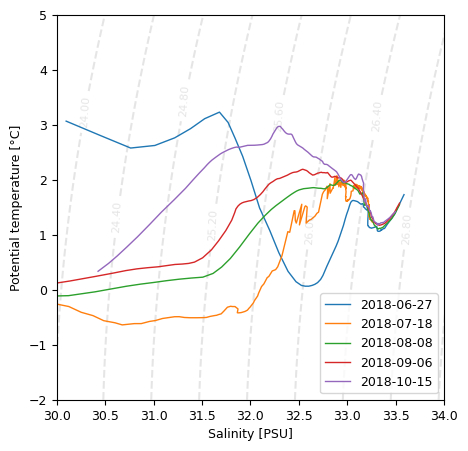

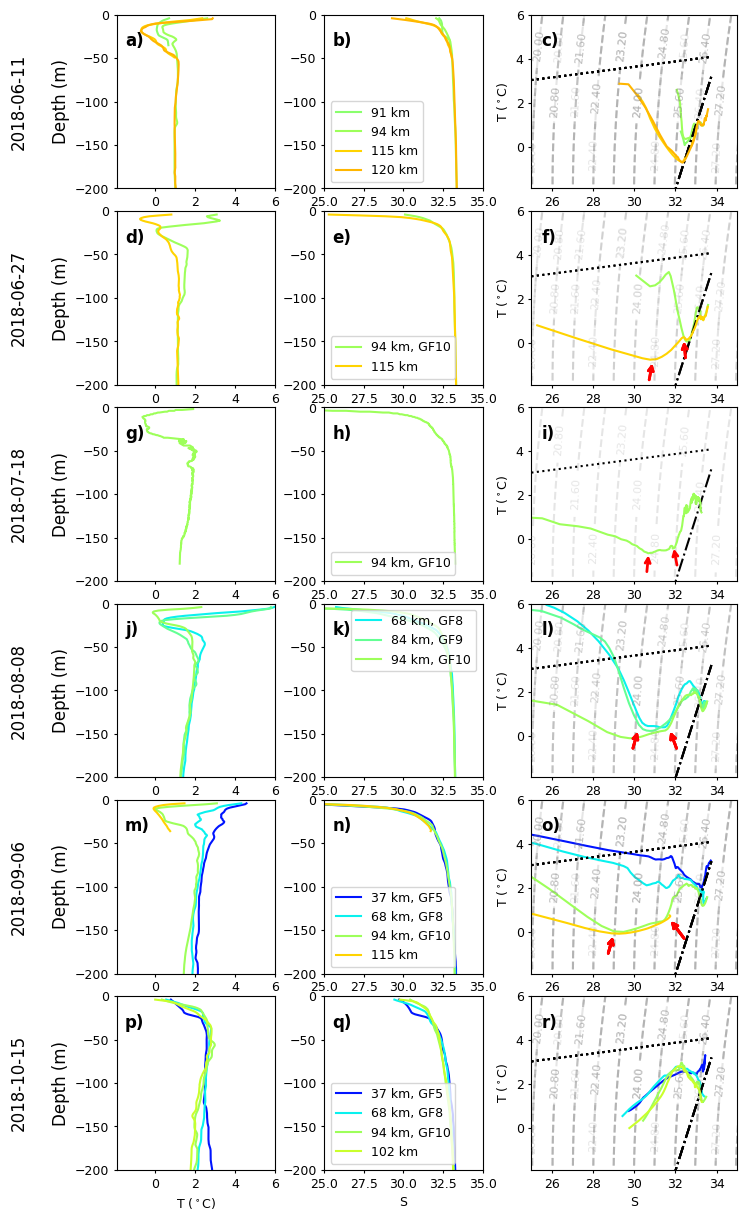

In [51]:

phases = ['', '', '', '', '',  '', '', '', '', '', '']
name = "summer_subglacial_with_arrow"
dates = [[ '2018-06-11', '2018-06-27', '2018-07-18' , '2018-08-08',  '2018-09-06', '2018-10-15']]
maxz = 200


figTS_overview, axTSover = plt.subplots(1, 1, figsize=[5,5])
axTSover.set_xlabel('Salinity [PSU]')
axTSover.set_ylabel('Potential temperature [°C]')
TSdiagram(axTSover, np.linspace(25, 35, 100), Tvals=np.linspace(-2,5, 100), levels=20, alpha=0.2)


rangeT = [-1.9, 6]
rangeS = [25,35]

WP_melt = dict(T=1, S=33)
WP_mix =  dict(T=4, S=33)


plot_height = 2.5
nr_rows = len(dates[0])

fig_profile, axs_profile = plt.subplots(nr_rows, 3, sharey=False, sharex=False, figsize=(8,nr_rows*plot_height), gridspec_kw={'width_ratios': [1, 1, 1.3]})

for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]']):
    for j, date in tqdm(enumerate(dates[0])):
        z_var ='Depth'
        fig1, df = plot_transect_from_big_file(date=date, variable_fill=contour_var)   # import df from file
        axTS = axs_profile[j,2]

        for d in df.Distance.sort_values().unique():
            if min(abs(np.array([37,68,94,118, 110])-d)) > 8 and len(df.Distance.sort_values().unique()) > 3:
                continue
            dfst = df[df.Distance == d].sort_values('Depth')[:-1]
            dfst = dfst.sort_values(z_var)

            color = cmap_profile((d-unique_distances[0])/ (unique_distances[-1]-unique_distances[0]))  # Assign color based on Distance
            label_name = make_label_name(dfst['St.'].values[0], d)
            axs_profile[j,i].plot(dfst[contour_var].rolling(window=5, center=True).mean(), dfst[z_var], label=label_name, color=color)
            axs_profile[j,i].set_xlim(rangeS)
            legendS = axs_profile[j,1].legend()

            # TS diagram
            if contour_var == 'Potential temperature [°C]': 
                axs_profile[j,i].set_xlim(rangeT)

                TSdiagram(axTS, np.linspace(rangeS[0]*0.9, rangeS[1]*1.1, 100), Tvals=np.linspace(rangeT[0]*0.9, rangeT[1]*1.1, 100), levels=20, alpha=0.2)
                dfstROL = dfst.rolling(window=5, center=True).mean()
                if maxz <= 200:
                    axTS.plot(np.linspace(rangeS[0], 33.75, 100), melt_line(T=WP_melt["T"], S=WP_melt["S"], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black', linestyle='-.')
                    axTS.plot(np.linspace(rangeS[0], 33.75, 100), mix_line(T=WP_mix["T"], S=WP_mix['S'], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black', linestyle=":")
                axTS.plot(dfstROL['Salinity [PSU]'], dfstROL[contour_var], label=f"{d:.0f} km, {dfst['St.'].values[0]}", color=color)
                axTS.set_ylim(rangeT)
                axTS.set_xlim(rangeS)
                axTS.tick_params(axis='both', which='major', length=2)
                if 'GF10' in dfst['St.'].to_list():
                    axTSover.plot(dfstROL['Salinity [PSU]'], dfstROL['Potential temperature [°C]'], linewidth=1, label=date)

                if date == '2018-06-27':
                    draw_arrow(axTS, 30.9, -0.8, 0.2, 1, color='red')
                    draw_arrow(axTS, 32.4, 0.2, -0.1, 1, color='red')

                if date == '2018-07-18':
                    draw_arrow(axTS, 30.7, -0.6, 0.1, 1, color='red')
                    draw_arrow(axTS, 31.9, -0.3, -0.2, 1, color='red')
                if date == '2018-08-08':
                    draw_arrow(axTS, 30.2, 0.3, 0.3, 1, color='red')
                    draw_arrow(axTS, 31.7, 0.3, -0.4, 1, color='red')
                if date == '2018-09-06':
                    draw_arrow(axTS, 29, -0.1, 0.3, 1, color='red')
                    draw_arrow(axTS, 31.7, 0.6, -0.8, 1, color='red')

        axs_profile[j,i].tick_params(axis='both', which='major', length=2)
        axs_profile[j,i].set_ylim([-maxz, 0])
        if phases[0] == '':
            ylabel = f'{date}'+'\n'+'\n'+ 'Depth (m)'
        else:
            ylabel = f'Phase {phases[j]}' +'\n'+ f'{date}'+'\n'+'\n'+ f'Depth (m)'
        axs_profile[j,0].set_ylabel(ylabel, fontsize=12)
        axs_profile[j,2].set_ylabel('T ($^\circ$C)')

for i, ax_prof in enumerate(axs_profile.flat):
    ax_prof.text(0.05, 0.9,  f'{string.ascii_lowercase[i]})', transform=ax_prof.transAxes, fontsize=12, fontweight='bold', va='top')

fig_profile.subplots_adjust(wspace=0.28, hspace=0.13)
axTSover.legend()
axTSover.set_xlim(30, 34)

axs_profile[-1,0].set_xlabel('T ($^\circ$C)')
axs_profile[-1,1].set_xlabel('S')
axs_profile[-1,2].set_xlabel('S')

# savefig
fig_profile.savefig(f'{figpath}/FigureS1_CTD_profiles_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')

# Figure S4: 
## CTD profiles winter strong circulation

3it [00:00,  9.11it/s]
3it [00:00,  9.01it/s]


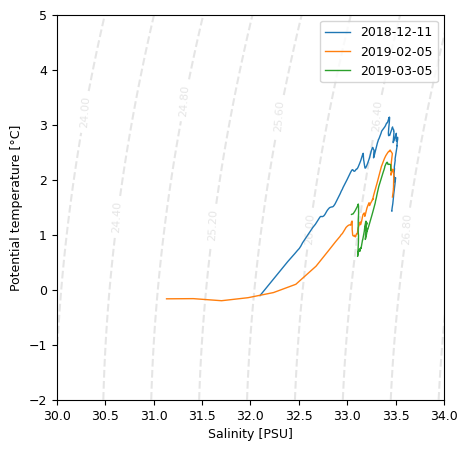

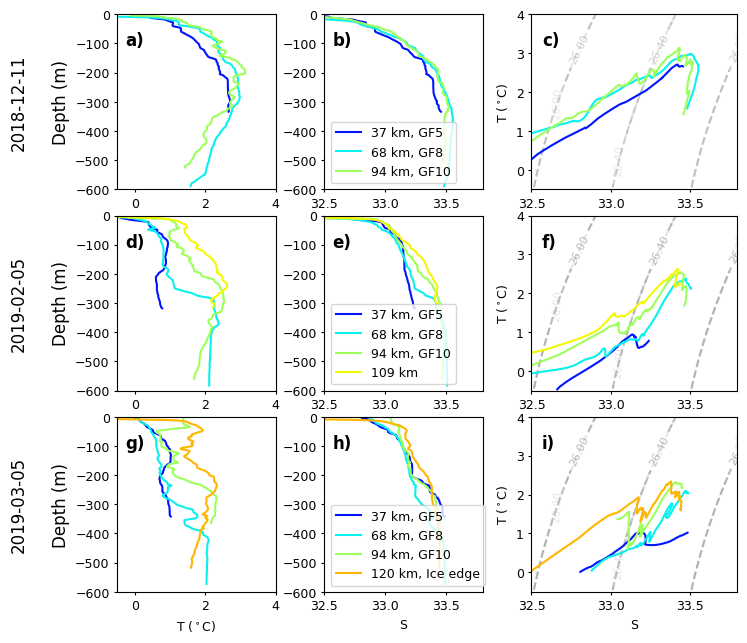

In [52]:
name = 'winter_intermediate'
dates = [[ '2018-12-11',  '2019-02-05',  '2019-03-05']]
rangeS, rangeT = [32.5,33.8], [-.5, 4]
maxz = 600

figTS_overview, axTSover= plt.subplots(1, 1, figsize=[5,5])
TSdiagram(axTSover, np.linspace(25, 35, 100), Tvals=np.linspace(-2,5, 100), levels=20, alpha=0.2)
axTSover.set_xlabel('Salinity [PSU]')
axTSover.set_ylabel('Potential temperature [°C]')



def add_depth_marker(dfst, point_depth, ax, marker, color):
    df_point_depth = dfst[dfst['Pressure'] == point_depth]
    ax.scatter(df_point_depth['Salinity [PSU]'], df_point_depth['Potential temperature [°C]'], s=20, edgecolors='black', facecolors=color, marker=marker, zorder=10)
    custom_marker = Line2D([0], [0], marker=marker, color='w', markerfacecolor='none', markeredgecolor='black', markersize=5, label=f'Depth: {point_depth}m')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(custom_marker)
    labels.append(f'Depth: {point_depth}m')
    ax.legend()




plot_height = 2.5
nr_rows = len(dates[0])

fig_profile, axs_profile = plt.subplots(nr_rows, 3, sharey=False, sharex=False, figsize=(8,nr_rows*plot_height), gridspec_kw={'width_ratios': [1, 1, 1.3]})

for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]',]):
    for j, date in tqdm(enumerate(dates[0])):
        z_var ='Depth'
        fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
        axTS = axs_profile[j,2]

        for d in df.Distance.sort_values().unique():
            if min(abs(np.array([37,68,94,118, 110])-d)) > 8 and len(df.Distance.sort_values().unique()) >3 : continue
            dfst = df[df.Distance == d].sort_values('Depth')[:-1]
            dfst = dfst.sort_values(z_var)
            color = cmap_profile((d-unique_distances[0])/ (unique_distances[-1]-unique_distances[0]))  # Assign color based on Distance
            label_name = make_label_name(station_name = dfst['St.'].values[0], distance= d)      
            axs_profile[j,i].plot(dfst[contour_var].rolling(window=5, center=True).mean(), dfst[z_var], label =label_name, color=color)
            axs_profile[j,i].set_xlim(rangeS)
            legendS = axs_profile[j,1].legend()


            # TS diagram
            if contour_var == 'Potential temperature [°C]': 
                axs_profile[j,i].set_xlim(rangeT)
                TSdiagram(axTS, np.linspace(rangeS[0]*0.9, rangeS[1]*1.1, 100), Tvals=np.linspace(rangeT[0]*0.9, rangeT[1]*1.1, 100), levels=20, alpha=0.2)
                dfstROL = dfst.rolling(window=5, center=True).mean()
                if maxz <=200:
                    axTS.plot(np.linspace(rangeS[0], 33.75, 100), melt_line(T=WP_melt["T"], S=WP_melt["S"], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle='-.')
                    axTS.plot(np.linspace(rangeS[0], 33.75, 100), mix_line(T=WP_mix["T"], S=WP_mix['S'], Sarray=np.linspace(rangeS[0], 33.75, 100)), color='black',  linestyle=":")

                axTS.plot(dfstROL['Salinity [PSU]'],dfstROL[contour_var],label = f"{d:.0f} km, {dfst['St.'].values[0]}", color=color,)

                axTS.set_ylim(rangeT)
                axTS.set_xlim(rangeS)
                axTS.tick_params(axis='both', which='major', length=2)
                if 'GF10' in dfst['St.'].to_list():

                    axTSover.plot(dfstROL['Salinity [PSU]'],dfstROL['Potential temperature [°C]'], linewidth=1, label=date)
                if date == '2018-06-27':
                    draw_arrow(axTS, 30.9, -0.8, 0.2, 1, color='red')
                    draw_arrow(axTS, 32.4, 0.2, -0.1, 1, color='red')

                if date == '2018-07-18':
                    draw_arrow(axTS, 30.7, -0.6, 0.1, 1, color='red')
                    draw_arrow(axTS, 31.9, -0.3, -0.2, 1, color='red')
                if date == '2018-08-08':
                    draw_arrow(axTS, 30.2, 0.3, 0.3, 1, color='red')
                    draw_arrow(axTS, 31.7, 0.3, -0.4, 1, color='red')
                if date == '2018-09-06':
                    draw_arrow(axTS, 29, -0.1, 0.3, 1, color='red')
                    draw_arrow(axTS, 31.7, 0.6, -0.8, 1, color='red')


        axs_profile[j,i].tick_params(axis='both', which='major', length=2)
        axs_profile[j,i].set_ylim([-maxz, 0])
        if phases[0] == '':
            ylabel = f'{date}'+'\n'+'\n'+ 'Depth (m)'
        else:
            ylabel = f'Phase {phases[j]}' +'\n'+ f'{date}'+'\n'+'\n'+ f'Depth (m)'
        axs_profile[j,0].set_ylabel(ylabel, fontsize=12)
        axs_profile[j,2].set_ylabel('T ($^\circ$C)')


for i, ax_prof in enumerate(axs_profile.flat):
    ax_prof.text(0.05, 0.9,  f'{string.ascii_lowercase[i]})', transform=ax_prof.transAxes, fontsize=12, fontweight='bold', va='top')

fig_profile.subplots_adjust(wspace=0.28, hspace=0.15)
axTSover.legend()
axTSover.set_xlim(30, 34)

axs_profile[-1,0].set_xlabel('T ($^\circ$C)')
axs_profile[-1,1].set_xlabel('S')
axs_profile[-1,2].set_xlabel('S')


# savefig
fig_profile.savefig(f'{figpath}/FigureS4_CTD_profiles_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')


# Figures S3
## CTD profile Inflow Intermediate

2it [00:00,  4.99it/s]
2it [00:00, 35.66it/s]


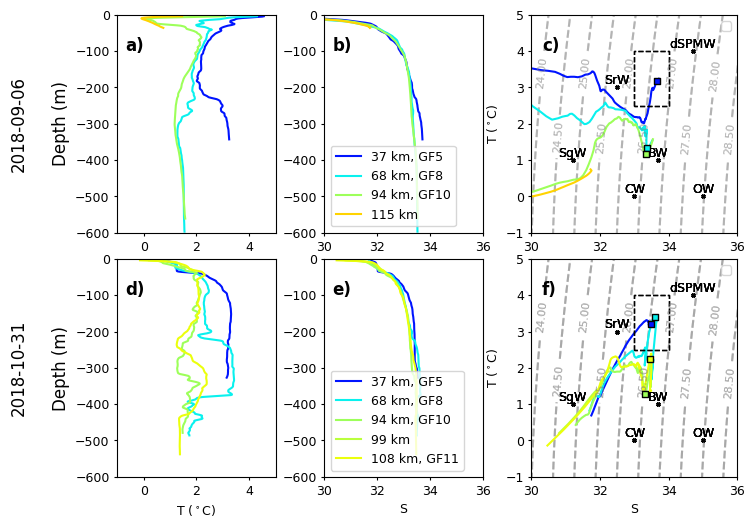

In [53]:
name = "intermediate_inflow"
dates = [[  '2018-09-06',  '2018-10-31',]]
maxz = 600

rangeT = [-1., 5]
rangeS = [30,36]

WP_melt = dict(T=2, S=33.2)

WP_melt = dict(T=1, S=33)
WP_mix =  dict(T=4, S=33)



plot_height = 3
nr_rows = len(dates[0])
fig_profile, axs_profile = plt.subplots(nr_rows, 3, sharey=False, sharex=False, figsize=(8,nr_rows*plot_height), gridspec_kw={'width_ratios': [1, 1, 1.3]})

for i, contour_var in enumerate(['Potential temperature [°C]','Salinity [PSU]',]):
    for j, date in tqdm(enumerate(dates[0])):
        z_var ='Depth'
        fig1, df = plot_transect_from_big_file(date =date, variable_fill=contour_var)   # import df from file
        axTS = axs_profile[j,2]

        for d in df.Distance.sort_values().unique():
            if min(abs(np.array([37,68,94,118, 110])-d)) > 8 and len(df.Distance.sort_values().unique()) >3 : continue
            dfst = df[df.Distance == d].sort_values('Depth')[:-1]
            dfst = dfst.sort_values(z_var)

            color = cmap_profile((d-unique_distances[0])/ (unique_distances[-1]-unique_distances[0]))  # Assign color based on Distance
            label_name = make_label_name(dfst['St.'].values[0], d)
            axs_profile[j,i].plot(dfst[contour_var].rolling(window=5, center=True).mean(), dfst[z_var], label = label_name , color=color)
            axs_profile[j,i].set_xlim(rangeS)

            if contour_var == 'Potential temperature [°C]': 
                axs_profile[j,i].set_xlim(rangeT)

                TSdiagram(axTS, np.linspace(rangeS[0]-0.1, rangeS[1]+0.1, 100), Tvals=np.linspace(rangeT[0]-0.1, rangeT[1]+0.1, 100), levels=10, alpha=0.2)
                dfstROL = dfst.rolling(window=5, center=True).mean()
                axTS.plot(dfstROL['Salinity [PSU]'],dfstROL[contour_var], color=color, label = "")
                legendTS = axTS.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)

                add_depth_marker(dfst, 300, axTS, 's', color)

                add_water_mass(axTS)
                axTS.set_ylim(rangeT)
                axTS.set_xlim(rangeS)
                axTS.tick_params(axis='both', which='major', length=2)


                if date == '2018-06-27':
                    add_arrow(axTS, 30.5, -0.8, 0.1, -10, color='red')
                    add_arrow(axTS, 32.4, 0.2, -0.1, -10, color='red')

                if date == '2018-07-18':
                    add_arrow(axTS, 30.5, -0.8, 0.1, -10, color='red')
                    add_arrow(axTS, 31.9, -0.3, -0.1, -10, color='red')


        axs_profile[j,i].tick_params(axis='both', which='major', length=2)
        axs_profile[j,i].set_ylim([-maxz, 0])
        ylabel = f'{date}'+'\n'+'\n'+ 'Depth (m)'

        axs_profile[j,0].set_ylabel(ylabel, fontsize=12)
        axs_profile[j,2].set_ylabel('T ($^\circ$C)')
        axTS.plot(*np.array(rectangle_corner_points(33, 34, 2.5, 4)).T,  linewidth=1, color='black', linestyle='--')
        legendS = axs_profile[j,1].legend()

for i, ax_prof in enumerate(axs_profile.flat):
    ax_prof.text(0.05, 0.9,  f'{string.ascii_lowercase[i]})', transform=ax_prof.transAxes, fontsize=12, fontweight='bold', va='top')

fig_profile.subplots_adjust(wspace=0.28, hspace=0.12)
axs_profile[-1,0].set_xlabel('T ($^\circ$C)')
axs_profile[-1,1].set_xlabel('S')
axs_profile[-1,2].set_xlabel('S')
fig_profile.savefig(f'{figpath}/FigureS3_CTD_profiles_{name}_{maxz}m.jpg', dpi=300, bbox_inches='tight')
